In [1]:
import numpy as np
import math as mth
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.colors import LogNorm

import Boundary_Functions as bf
import timeit
import tables
import h5py

from scipy import stats
from scipy import optimize
from scipy import *
import scipy

#import warnings
#warnings.filterwarnings("ignore")

start = timeit.default_timer()

In [2]:
uscal=5
vscal=1

If hd5 is used, uscal and vscal reduce arrays by their value in order to prevent memory overflow. Use when h5 files are very large (i.e. >500MB) otherwise (u,v) plots will overflow memory.

In [3]:
rnputil=np.load('rnputil.npy')
wHD=rnputil[8]
print(wHD)

if wHD==True or wHD==1.0 or wHD=='True':
    urange=np.load('urange.npy')[::uscal]
    vrange=np.load('vrange.npy')[::vscal]
if wHD==False or wHD==0.0 or wHD==None or wHD=='False':
    urange=np.load('urange.npy')
    vrange=np.load('vrange.npy')

True


In [4]:
if wHD==True or wHD==1.0 or wHD=='True':
    with h5py.File('rnp.h5','r') as f:
        r_group_key = list(f.keys())[0]
        rnpi=f[r_group_key]
        rnp = np.asarray(rnpi[::uscal,::vscal])
    with h5py.File('signp.h5','r') as f:
        sig_group_key = list(f.keys())[0]
        signpi=f[sig_group_key]
        signp = np.asarray(signpi[::uscal,::vscal])
    with h5py.File('phinp.h5','r') as f:
        phi_group_key = list(f.keys())[0]
        phinpi=f[phi_group_key]
        phinp = np.asarray(phinpi[::uscal,::vscal])
    with h5py.File('massnp.h5','r') as f:
        mass_group_key = list(f.keys())[0]
        massnpi=f[mass_group_key]
        massnp = np.asarray(massnpi[::uscal,::vscal])
    
    print(str(rnp.nbytes)+" bytes")
    print("Hd5 files used")

if wHD==False or wHD==0.0 or wHD==None or wHD=='False':
    rnp=np.load('rnp.npy')
    signp=np.load('sig.npy')
    phinp=np.load('phi.npy')
    massnp=np.load('mass.npy')
    print("Numpy arrays used")

80800000 bytes
Hd5 files used


In [5]:
print(rnputil)

N=int(rnputil[0])
Nu=len(urange)#int(rnputil[1])
Nv=len(vrange)#int(rnputil[2])
ru0=float(rnputil[3])
dr0v=float(rnputil[4])
M0=float(rnputil[5])
Q=float(rnputil[6])
Lambda=float(rnputil[7])
umax=np.nanmax(urange)
vmax=np.nanmax(vrange)
print(vmax)

dv0=vrange[1]-vrange[0]

    
numpoints=Nu*Nv
#print(str(numpoints)+" points")

if Q==0.0:
    predtime=numpoints/(144935)
if Q>0.0:
    predtime=numpoints/(259000)
print("Runtime: about "+str(format(predtime/60,'.2f'))+" minutes")

['50480000' '2524' '20000' '2.0' '0.0225625' '1.0' '0.95' '0.0' 'True'
 '0.0' 'edd']
199.99
Runtime: about 0.65 minutes


In [6]:
M=massnp[0][-1]
Q=Q#*M
Lambda=Lambda#/M**2.0


print(M,Q,Lambda)

def fr(r,M,Q,Lambda):
    return 1-2*M/r+Q**2.0/r**2.0-Lambda*r**2.0/3.0

sol = optimize.root(fr,[0.4,1.2,16.0],args=(M,Q,Lambda),tol=10**(-12), method='hybr')
rminus=sol.x[0]#+.035
rplus=sol.x[1]
rcosm=sol.x[2]

def dfr(r,M,Q,Lambda):
    return -2*(Lambda*r**4-3*M*r+3*Q**2)/(3*r**3)

print(rminus,rplus,rcosm)

print(fr(np.array([rminus,rplus,rcosm]),M,Q,Lambda))

1.000055055997037 0.95 0.0
0.6868813772265088 1.3125820256617307 -88661.97465011547
[9.91165910e-04 3.65620650e-05 1.00002256e+00]


In [7]:
def kappa(fr,r,M,Q,Lambda):
    return 0.5*np.abs(scipy.misc.derivative(fr,r,dx=.00001,n=1,args=(M,Q,Lambda)))
#def kappa2(dfr,r,M,Q,Lambda):
    #return optimize.root(dfr,[0.01,1.5,50.0],args=(M,Q,Lambda),tol=10**(-10), method='hybr')

kappaplus=kappa(fr,rplus,M,Q,Lambda)
kappaminus=kappa(fr,rminus,M,Q,Lambda)
kappacosm=kappa(fr,rcosm,M,Q,Lambda)
print(kappaplus,kappaminus,kappacosm)
###double-check for Lambda=0
###kappaminus
print(np.abs((M*rminus-Q**2)/rminus**3.0))
print(0.5*np.abs(dfr(rminus,M,Q,Lambda)))
###


0.18137102244519807 0.6652193379697025 1.2212453270876722e-10
0.6652193372422096
0.6652193372422099


masslist=[1.0,1.00001,1.0001,1.001,1.01]

plot1=plt.pcolormesh(vrange,urange,np.ma.masked_invalid(phinp),cmap=plt.cm.cool,vmin=0.0,vmax=np.nanmax(phinp))
#plot4=plt.contour(vrange,urange,np.ma.masked_invalid(phinp), masslist,linewidths=0.5,colors='black',extent=(0,vmax,0,umax),aspect='auto',origin='lower')
#plt.clabel(plot4, masslist,  inline=0, inline_spacing=0, fmt='%1.6f',rightside_up=True,fontsize=8)
plt.xlabel('v')
plt.ylabel('u')
#plt.xlim(0,vmax)
#plt.ylim(0,13)
plt.ylim(0,umax)
plt.xlim(0,vmax)
#plt.ylim(9.2758,9.2761)
plt.colorbar(plot1)
plt.title(r'$\Phi$ vs (u,v) Coordinates')
plt.show()



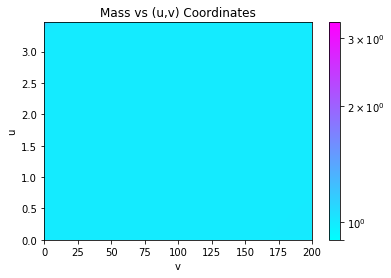

In [8]:
try:
    plot1=plt.pcolormesh(vrange,urange,np.ma.masked_invalid(massnp),cmap=plt.cm.cool,norm=LogNorm(vmin=0.9, vmax=np.nanmax(massnp)))#vmin=0,vmax=2.0)
    #plot4=plt.contour(vrange,urange,np.ma.masked_invalid(massnp), masslist,linewidths=0.5,colors='black',extent=(0,vmax,0,umax),aspect='auto',origin='lower')
    #plt.clabel(plot4, masslist, inline=0, inline_spacing=0, fmt='%1.6f',rightside_up=True, fontsize=8)
    plt.xlabel('v')
    plt.ylabel('u')
    #plt.xlim(0,vmax)
    plt.ylim(0,umax)
    #plt.xlim(0,10)
    plt.xlim(0,vmax)
    #plt.ylim(9.2758,9.2761)
    plt.colorbar(plot1)
    plt.title('Mass vs (u,v) Coordinates')
    plt.show()
except ValueError:
    pass

In [9]:
print(Nu)
print(Nv)
print(massnp[1][-1])
print(massnp[:,:])
print(np.nanmax(massnp))
print(np.nanmin(massnp))
print(np.argmax(massnp[-10]))

505
20000
1.001587463233347
[[1.         1.         1.         ... 1.00005506 1.00005506 1.00005506]
 [1.         1.         1.         ... 1.00158727 1.00158737 1.00158746]
 [1.         1.         1.         ... 1.00156003 1.00156013 1.00156022]
 ...
 [1.         3.30249726 2.79584791 ... 0.99936345 0.99936327 0.9993631 ]
 [1.         3.30275188 2.79604426 ... 0.99936345 0.99936327 0.9993631 ]
 [1.         3.30297894 2.79621936 ... 0.99936345 0.99936327 0.9993631 ]]
3.3029789389753383
0.9984608635168479
1


In [10]:
#print(signp[-2])
#for i in massnp[-3]:
    #print(i)

In [11]:
print(Nu)

505


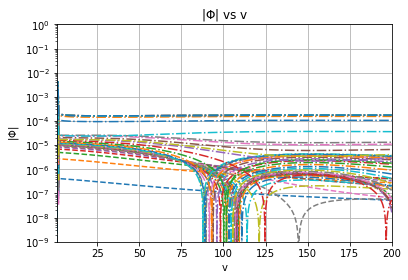

/home/brandon/.conda/envs/pycbc/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in double_scalars
/home/brandon/.conda/envs/pycbc/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in double_scalars


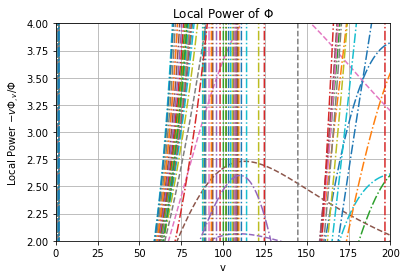

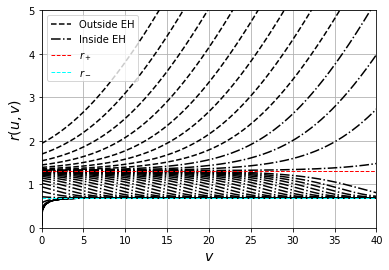

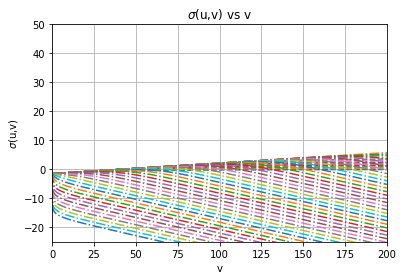

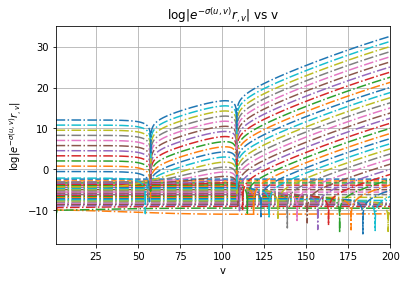

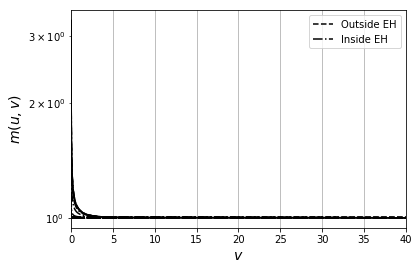

In [12]:

#uNEH=800
#ustep=100
#uN1=uNEH-mth.floor(uNEH/100)*100
#Numax=Nu

uNEH=80
#uNEH=49
ustep=10
uN1=uNEH-mth.floor(uNEH/10)*10+2
Numax=int(Nu)#-400

#print(uN2)
localpowerlist=np.zeros((Nv))*np.nan
etemplist=np.zeros((Nv))*np.nan
power1list=[]
power3list=[]

vrange2=vrange*dr0v/0.5/np.abs(1-2*massnp[0][0]/rnp[0][0]+Q**2/rnp[0][0]**2-Lambda*(rnp[0][0])**2.0/3.0)


#for j in range(0,Nv-1):
    #v=j*vmax/(Nv)
    #localpowerlist[j]=-v*(phinp[uN2][j+1]-phinp[uN2][j])/(dv0*phinp[uN2][j])
    
uN=uN1
while uN < Numax:
    #print(uN)
    if uN<uNEH:
        sample3=plt.plot(vrange,abs(phinp[uN]),'--')
    if uN==uNEH:
        sample3=plt.plot(vrange,abs(phinp[uN]))
    if uN>uNEH:
        sample3=plt.plot(vrange,abs(phinp[uN]),'-.')
    #sample3=plt.plot(vrange,abs(phinp[uN1+uN]))
    uN+=ustep
    
plt.xlabel('v')
plt.ylabel(r'$|\Phi|$')
plt.ylim(0.000000001,1.0)
plt.xlim(1,vmax)
plt.grid()
#plt.xscale('log')
plt.yscale('log')
plt.title(r'$|\Phi|$ vs v')
#plt.savefig('num-rel-pics/Phi v q-0.png',dpi=300,bbox_inches="tight")
plt.show()    

#sample3=plt.plot(vrange,localpowerlist)
uN=uN1
while uN< Numax:
    for j in range(0,Nv-1):
        v=j*vmax/(Nv)
        localpowerlist[j]=-v*(phinp[uN][j+1]-phinp[uN][j])/((vrange[j+1]-vrange[j])*phinp[uN][j])
    
    if uN<uNEH:
        sample3=plt.plot(vrange,localpowerlist,'--')
    if uN==uNEH:
        sample3=plt.plot(vrange,localpowerlist)
    if uN>uNEH:
        sample3=plt.plot(vrange,localpowerlist,'-.')
    #sample3=plt.plot(vrange,localpowerlist)+
    uN+=ustep
plt.xlim(0,vmax)
plt.xlabel('v')
plt.ylabel(r'Local Power $-v \Phi_{,v}/\Phi$')
plt.ylim(2,4)
plt.grid()
plt.title(r'Local Power of $\Phi$') #(u='+str(uN2u)+')')#+',uEH='+str(uEH*umax)+')')
#plt.savefig('num-rel-pics/Phipower.png',dpi=300,bbox_inches="tight")
plt.show()

uN=uN1

while uN< Numax:
    if uN<uNEH:
        sample3=plt.plot(vrange2,rnp[uN,:],'--',color='black')
    if uN==uNEH:
        sample3=plt.plot(vrange2,rnp[uN,:])
    if uN>uNEH:
        sample3=plt.plot(vrange2,rnp[uN,:],'-.',color='black')
    #sample3=plt.plot(vrange,rnp[uN1+uN,:])
    uN+=ustep

plt.plot([nan],[nan],'--',color='black',label='Outside EH')
plt.plot([nan],[nan],'-.',color='black',label='Inside EH')
plt.plot([0,vmax],[rplus,rplus],'r--',color='red',linewidth=1.0,label=r'$r_+$')
plt.plot([0,vmax],[rminus,rminus],'r--',color='cyan',linewidth=1.0,label=r'$r_-$')
plt.xlim(0,max(vrange2))
plt.xlabel(r'$v$',fontsize=14)
plt.ylabel(r'$r(u,v)$',fontsize=14)
plt.ylim(0,5)
#plt.ylim(.2,.4)
#plt.xscale('log')
#plt.yscale('log')
plt.grid()
plt.legend(loc='best')
#plt.title('r(u,v) vs v') #(u='+str(uN2u)+')')#+',uEH='+str(uEH*umax)+')')
#plt.savefig('num-rel-pics/r_v.png',dpi=300)

plt.show()

uN=uN1
while uN< Numax:
    if uN<uNEH:
        sample3=plt.plot(vrange,signp[uN,:],'--',label='u='+str(uN))
    if uN==uNEH:
        sample3=plt.plot(vrange,signp[uN,:])
    if uN>uNEH:
        sample3=plt.plot(vrange,signp[uN,:],'-.')
    #sample3=plt.plot(vrange,signp[uN1+uN,:])
    uN+=ustep
plt.xlim(0,vmax)
plt.xlabel('v')
plt.ylabel(r'$\sigma$(u,v)')
plt.ylim(-25,50)
#plt.xscale('log')
#plt.yscale('log')
plt.grid()
plt.title(r'$\sigma$(u,v) vs v') #(u='+str(uN2u)+')')#+',uEH='+str(uEH*umax)+')')
#plt.savefig('sigEHLambda.png',dpi=300,bbox_inches="tight")
plt.show()
#print(localpowerlist[-200])

uN=uN1
while uN< Numax:
    for j in range(0,Nv-1):
        try:
            etemplist[j]=abs(mth.exp(-signp[uN][j])*(rnp[uN][j+1]-rnp[uN][j])/(vrange[j+1]-vrange[j]))
        except OverflowError:
            etemplist[j]=np.nan
    if uN<uNEH:
        sample3=plt.plot(vrange,np.log(etemplist),'--')
    if uN==uNEH:
        sample3=plt.plot(vrange,np.log(etemplist))
    if uN>uNEH:
        sample3=plt.plot(vrange,np.log(etemplist),'-.')
    #print(etemplist)
    uN+=ustep
plt.xlim(1,vmax)
#plt.ylim(-1,10)
plt.xlabel('v')
plt.ylabel(r'$\log{|e^{-\sigma(u,v)} r_{,v}|}$')
#plt.ylim(2,4)
#plt.xscale('log')
#plt.yscale('log')
plt.grid()
plt.title(r'$\log{|e^{-\sigma(u,v)} r_{,v}|}$ vs v') #(u='+str(uN2u)+')')#+',uEH='+str(uEH*umax)+')')
#plt.savefig('weird-Phi-v_0.png',dpi=300,bbox_inches="tight")
plt.show()


uN=uN1
while uN< Numax:
    if uN<uNEH:
        #sample3=plt.plot(vrange,np.log(massnp[uN,:]),'--')
        sample3=plt.plot(vrange2,massnp[uN,:],'--',color='black')
    if uN==uNEH:
        #sample3=plt.plot(vrange,np.log(massnp[uN,:]))
        sample3=plt.plot(vrange2,massnp[uN,:])
    if uN>uNEH:
        #sample3=plt.plot(vrange,np.log(massnp[uN,:]),'-.')
        sample3=plt.plot(vrange2,massnp[uN,:],'-.',color='black')
        
    #sample3=plt.plot(vrange,rnp[uN1+uN,:])
    #print(urange[uN])
    uN+=ustep
plt.plot([nan],[nan],'--',color='black',label='Outside EH')
plt.plot([nan],[nan],'-.',color='black',label='Inside EH')
plt.xlim(0,max(vrange2))
plt.xlabel(r'$v$',fontsize=14)
plt.ylabel(r'$m(u,v)$',fontsize=14)
#plt.ylim(.9,10**17)
#plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.legend(loc='best')
#plt.title('Mass Parameter vs v') #(u='+str(uN2u)+')')#+',uEH='+str(uEH*umax)+')')
plt.savefig('num-rel-pics/m_v.png',dpi=300)
plt.show()


In [13]:
#print(massnp[uNEH][-1])
#print(np.nanmax(massnp))
#print(vrange)

100 1000 90
[nan nan]


/home/brandon/.conda/envs/pycbc/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
/home/brandon/.conda/envs/pycbc/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys
/home/brandon/.conda/envs/pycbc/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
/home/brandon/.conda/envs/pycbc/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  


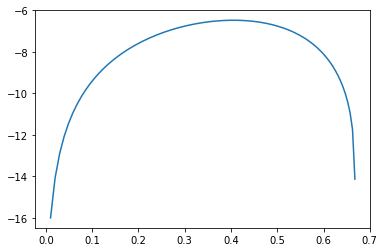

In [14]:
v1=int(1/vmax*Nv)#2000
v2=int(10/vmax*Nv)#3000
u3=uNEH+10
print(v1,v2,u3)
#print(stats.linregress(vrange[v1:v2],localpowerlist[v1:v2]))

print(np.polyfit(np.log(vrange[v1:v2]),np.log(phinp[uNEH][v1:v2]),1.0))
plt.plot(np.log(vrange[v1:v2]),np.log(phinp[uNEH][v1:v2]))
plt.show()


In [15]:
print(Nu,Nv)
print(vmax)
#print(Lambda)

505 20000
199.99


###Standard Coordinates

0 20000 -1
0.04509948270109227
[0.         0.04431911 0.08861392 0.13288442 0.17713065 0.22135262
 0.26555034 0.30972383 0.3538731  0.39799819]
[-0.00040775  0.04884904]


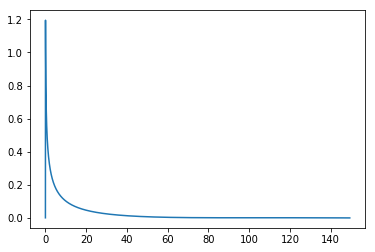

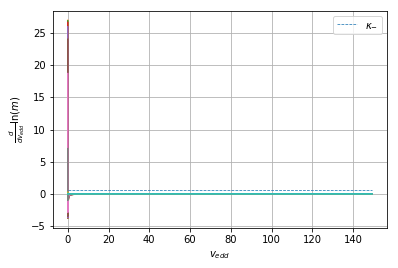

In [16]:
v1=0#Nv-4#int(50/vmax*Nv)#2000
v2=Nv#int(85/vmax*Nv)#3000
u3=-1
u4=0
print(v1,v2,u3)
print(rnp[u3][v1])
#print(massnp[u3])

vmaxh=vmax

#cornp=vmaxh/float(Nv)*np.full(Nv,1.0)*2.0/(np.abs(1-2*massnp[u4]/rnp[u4]+Q**2/rnp[u4]**2-Lambda*(rnp[u4])**2.0/3.0)*np.exp(signp[u4])+np.roll(np.abs(1-2*massnp[u4]/rnp[u4]+Q**2/rnp[u4]**2-Lambda*(rnp[u4])**2.0/3)*np.exp(signp[u4]),1))*np.abs(1-2*massnp[u4][0]/rnp[u4][0]+Q**2/rnp[u4][0]**2-Lambda*(rnp[u4][0])**2.0/3.0)
cornp=vmaxh/float(Nv)*np.full(Nv,1.0)/(np.roll(np.abs(1-2*massnp[u4]/rnp[u4]+Q**2/rnp[u4]**2-Lambda*(rnp[u4])**2.0/3.0)*np.exp(signp[u4]),1))*np.abs(1-2*massnp[u4][0]/rnp[u4][0]+Q**2/rnp[u4][0]**2-Lambda*(rnp[u4][0])**2.0/3.0)
vrange2=np.cumsum(cornp)-cornp[0]



print(vrange2[0:10])#-vrange2[0:10])

#plt.plot(vrange)
#plt.plot(vrange2)
#plt.show()

#print(vrange2)

print(np.polyfit(vrange2[v1:v2],np.log(np.abs(massnp[u3][v1:v2])),1.0))#/signp[u3][v1])#*32/rnp[u3][v1]*np.exp(-rnp[u3][v1]/2))
#plt.plot(vrange[v1:v2],massnp[u3][v1:v2])
#plt.plot(vrange[v1:v2],np.log(massnp[u3][v1:v2]),'--')
plt.plot(vrange2[v1:v2],np.log(np.abs(massnp[u3][v1:v2])))
plt.show()

Nua=int(Nu/1.0)
numulines=int((Nu-1)/10.0)

for i in range(numulines):
    i=-i*int(Nu/numulines)
    plt.plot(vrange2[v1:v2-1],diff(np.log(np.abs(massnp[i][v1:v2])))/diff(vrange2[v1:v2]))
#if Lambda==0.0:
plt.plot([0,max(vrange2[v1:v2-1])],[kappaminus,kappaminus],'--',label=r'$\kappa_{-}$',linewidth=0.75)
if Lambda>0.0:
    plt.plot([0,max(vrange2[v1:v2-1])],[kappaminus-kappacosm,kappaminus-kappacosm],'--',label=r'$\kappa_{-}-\kappa_{c}$')
plt.legend(loc='best')
plt.ylabel(r'$\frac{d}{dv_{edd}} \ln(m)$')
plt.xlabel(r'$v_{edd}$')
plt.grid()
#plt.ylim(0,1)
#plt.savefig('num-rel-pics/slope_m_Mf='+str(M)+'_Q='+str(Q)+'_Lambda='+str(Lambda)+'_N=100_stan.png',dpi=300)
plt.show()


In [17]:
#print(kappa(fr,rminus,massnp[u3],Q,Lambda))
print(kappa(fr,rminus,M,Q,Lambda))
####Low Q-regime
print(kappa(fr,rminus,M,Q,Lambda)-kappa(fr,rcosm,M,Q,Lambda))
###High Q-regime
print(kappa(fr,rminus,M,Q,Lambda)-kappa(fr,rplus,M,Q,Lambda))

print(Nu,Nv)
#print(kappa(fr,rcosm,M,Q,Lambda)-kappa(fr,rplus,M,Q,Lambda))
#print(2*kappa(fr,rminus,M,Q,Lambda)-kappa(fr,rplus,M,Q,Lambda)-kappa(fr,rcosm,M,Q,Lambda))

0.6652193379697025
0.6652193378475779
0.48384831552450436
505 20000


###Eddington Coordinates

0.1128125
[-8.79424010e-05  2.87952402e-03]


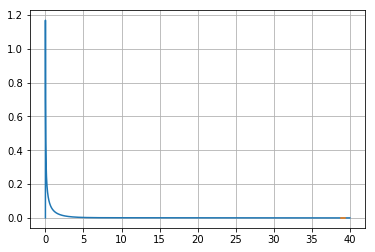

In [18]:
v1=Nv-600#Nv-50000#75000#Nv-90000
v2=Nv-300#-20000
u3=-35
u4=0

vmaxh=vmax

vrange2=vrange*dr0v/0.5/np.abs(1-2*massnp[0][0]/rnp[0][0]+Q**2/rnp[0][0]**2-Lambda*(rnp[0][0])**2.0/3.0)

print(0.5*np.abs(1-2*massnp[u4][0]/rnp[u4][0]+Q**2/rnp[u4][0]**2-Lambda*(rnp[u4][0])**2.0/3.0))

plt.plot(vrange2,np.log(np.abs(massnp[u3])))

print(np.polyfit(vrange2[v1:v2],np.log(np.abs(massnp[u3][v1:v2])),1.0))#/signp[u3][v1])#*32/rnp[u3][v1]*np.exp(-rnp[u3][v1]/2))
#plt.plot(vrange[v1:v2],massnp[u3][v1:v2])
#plt.plot(vrange[v1:v2],np.log(massnp[u3][v1:v2]),'--')
plt.plot(vrange2[v1:v2],np.log(np.abs(massnp[u3][v1:v2])))
plt.grid()
#plt.savefig('num-rel-pics/measured slope_Q=.9.png')
plt.show()




In [19]:
print(kappa(fr,rminus,M,Q,Lambda))
####Low Q-regime
print(kappa(fr,rminus,M,Q,Lambda)-kappa(fr,rcosm,M,Q,Lambda))
###High Q-regime
print(kappa(fr,rminus,M,Q,Lambda)-kappa(fr,rplus,M,Q,Lambda))

print(2*kappaminus-kappaminus-kappacosm)

print(Nu,Nv)

0.6652193379697025
0.6652193378475779
0.48384831552450436
0.6652193378475779
505 20000


505


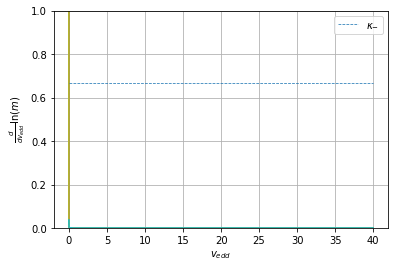

In [20]:
print(Nu)
v1=0
v2=Nv

Nua=int(Nu/1.0)
numulines=int((Nu-1)/10)

for i in range(numulines):
    i=-i*int(Nu/numulines)
    plt.plot(vrange2[v1:v2-1],diff(np.log(np.abs(massnp[i][v1:v2])))/diff(vrange2[v1:v2]))
#if Lambda==0.0:
plt.plot([0,max(vrange2[v1:v2-1])],[kappaminus,kappaminus],'--',label=r'$\kappa_{-}$',linewidth=0.75)
if Lambda>0.0:
    plt.plot([0,max(vrange2[v1:v2-1])],[kappaminus-2*kappacosm,kappaminus-2*kappacosm],'--',label=r'$\kappa_{-}-2\kappa_{c}$')
    plt.plot([0,max(vrange2[v1:v2-1])],[kappaminus-kappaplus,kappaminus-kappaplus],'--',label=r'$\kappa_{-}-\kappa_{+}$')
    plt.plot([0,max(vrange2[v1:v2-1])],[kappaminus-2*kappaplus,kappaminus-2*kappaplus],'--',label=r'$\kappa_{-}-2\kappa_{+}$')
    
plt.legend(loc='best')
plt.ylabel(r'$\frac{d}{dv_{edd}} \ln(m)$')
plt.xlabel(r'$v_{edd}$')
plt.grid()
plt.ylim(0.0,1.0)
#plt.savefig('num-rel-pics/slope_m_Mf='+str(M)+'_Q='+str(Q)+'_Lambda='+str(Lambda)+'_N=200_Nv=1000_Tol=.25_edd.png',dpi=300)
plt.show()
#print(M,)

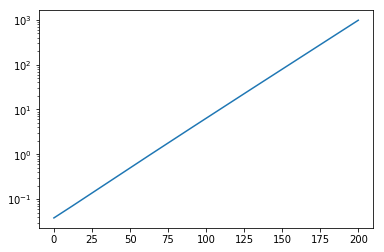

In [21]:
plt.plot(vrange,np.abs(np.exp(signp[u4])/(32*massnp[u4]**3.0/rnp[u4]*np.exp(-rnp[u4]/(2*massnp[u4])))))
plt.yscale('log')
plt.show()

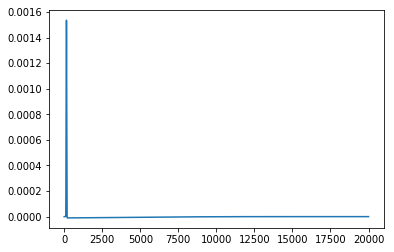

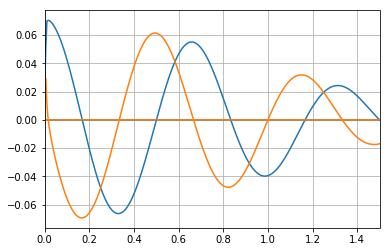

In [22]:
plt.plot(phinp[uNEH,:])
plt.show()


freq=np.fft.fftfreq(vrange.shape[-1],dv0)

Phifft=np.fft.fft(phinp[uNEH,:])
plt.plot(freq,Phifft.real,freq,Phifft.imag)
plt.xlim(0,1.5)
plt.grid()
plt.show()

In [23]:
True=False
if f is p
asdf

SyntaxError: invalid syntax (<ipython-input-23-b548891734d8>, line 2)

In [ ]:
localpowerv=np.zeros((Nu,Nv))*np.nan

for i in range(0,Nu-1):
    for j in range(0,Nv-1):
        v=j*vmax/(Nv)
        localpowerv[i][j]=-v*(phinp[i][j+1]-phinp[i][j])/(dv0*phinp[i][j])
        

In [ ]:
powerlist=[1,2,3,4,5]

#plot1=plt.pcolormesh(vrange,urange,np.ma.masked_invalid(localpowerv),cmap=plt.cm.cool,vmin=0.0,vmax=5.0)
#plot4=plt.contour(vrange,urange,np.ma.masked_invalid(localpowerv), powerlist,linewidths=0.5,colors='black',extent=(0,vmax,0,umax),aspect='auto',origin='lower')

plot1=plt.imshow(np.ma.masked_invalid(localpowerv),cmap=plt.cm.cool,extent=(0,vmax,0,umax),aspect='auto',origin='lower',vmin=0.0,vmax=5.0)
plot4=plt.contour(np.ma.masked_invalid(localpowerv), powerlist,linewidths=0.5,colors='black',extent=(0,vmax,0,umax),aspect='auto',origin='lower')

plt.clabel(plot4, powerlist,inline=0, inline_spacing=0, fmt='%1.6f',rightside_up=True,fontsize=8)
#sample3=plt.plot(vrange[-1],drdvnplist)
#sample3=plt.plot(vrange,dsigdvnplist)
plt.xlabel('v')
plt.ylabel('u')
#plt.xlim(0,400)
#plt.ylim(9.36,9.37)
#plt.ylim(0,1000)
plt.colorbar(plot1)
plt.title('Power Law ')
#plt.savefig('RN-err-max-N_60.png',dpi=300)
plt.show()

In [ ]:
ueddrange=np.empty((Nu))
ueddrange[0]=0.0
M=massnp[1][-1]

for i in range(0,Nu-1):
    
    #print(M)
    ueddrange[i+1]=ueddrange[i]+(urange[i+1]-urange[i])*(1-2*M/rnp[i][0]+Q**2/rnp[i][0]**2)**(1)*mth.exp(-signp[i][0])
    
plt.plot(ueddrange)
plt.plot(urange)
plt.ylim(0,20)
plt.xlabel('Point Number')
plt.ylabel('u')
plt.grid()
plt.show()



In [ ]:
localpoweru=np.zeros((Nu,Nv))*np.nan

for i in range(0,Nu-1):
    for j in range(0,Nv-1):
        #u=i*umax/(Nu)
        #=urange[i]
        u=ueddrange[i]
        try:
            localpoweru[i][j]=-u*(phinp[i+1][j]-phinp[i][j])/(du0*phinp[i][j])#*(1-2*massnp[i][j]/rnp[i][j]+Q**2/rnp[i][j]**2)**(-1)*mth.exp(signp[i][j])
        except:
            localpoweru[i][j]=np.nan

In [ ]:
powerlist=[1,2,3,4,5]

#plot1=plt.pcolormesh(vrange,urange,np.ma.masked_invalid(localpoweru),cmap=plt.cm.cool,vmin=0.0,vmax=10.0)
#plot4=plt.contour(vrange,urange,np.ma.masked_invalid(localpoweru), powerlist,linewidths=0.5,colors='black',extent=(0,vmax,0,umax),aspect='auto',origin='lower')


plot1=plt.imshow(np.ma.masked_invalid(localpoweru),cmap=plt.cm.cool,extent=(0,vmax,0,umax),aspect='auto',origin='lower',vmin=0.0,vmax=5.0)
plot4=plt.contour(np.ma.masked_invalid(localpoweru), powerlist,linewidths=0.5,colors='black',extent=(0,vmax,0,umax),aspect='auto',origin='lower')

plt.clabel(plot4, powerlist,inline=0, inline_spacing=0, fmt='%1.6f',rightside_up=True,fontsize=8)
#sample3=plt.plot(vrange[-1],drdvnplist)
#sample3=plt.plot(vrange,dsigdvnplist)
plt.xlabel('v')
plt.ylabel('u')
plt.xlim(0,vmax)
#plt.ylim(9.0,10.8)
plt.colorbar(plot1)
plt.title('Power Law')
#plt.savefig('RN-err-max-N_60.png',dpi=300)
plt.show()

In [ ]:
sample3=plt.plot(abs(phinp[:,-1]))
plt.xlabel('u')
plt.ylabel(r'$|\Phi|$')
#plt.ylim(0.0000000001,0.001)
#plt.xlim(18.2999,18.299905)
#plt.xlim(0.,100)
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.title(r'$|\Phi|$ along v=1000')
plt.savefig('Phi1.png',dpi=300,bbox_inches="tight")
plt.show()  


sample3=plt.plot(localpoweru[:,-2])
#plt.xlim(0,1000)
plt.xlabel('u')
plt.ylabel(r'Local Power $-u \Phi_{,u}/\Phi$')
plt.ylim(0,4)
#plt.xlim(11,20)
plt.grid()
plt.title('Test of Prices Law (goes as 2)')
plt.savefig('Phi2.png',dpi=300,bbox_inches="tight")
plt.show()

In [ ]:
stop = timeit.default_timer()

In [ ]:
acttime=stop - start

numpoints=Nu*Nv



print(str(acttime)+' seconds')
print(str((acttime)/60)+' minutes')
print(str((acttime)/3600)+' hours')

print(str(numpoints)+' points')

print(str((numpoints)/(stop - start))+' points per second') 

exttimef=(acttime-predtime)/60

exttime=format(abs((acttime-predtime)/60),'.2f')
if exttimef>0.0:
    print("Took "+str(exttime)+" more minutes")
if exttimef<0.0:
    print("Took "+str(exttime)+" less minutes")
if exttimef==0.0:
    print("Took exactly the right time!!!!")

In [ ]:
uc=1000
vc=-10
print(2.0/1.75)
print((1-2*massnp[uc][vc]/rnp[uc][vc]+Q**2/rnp[uc][vc]**2)**(-1)*mth.exp(-signp[uc][vc]))
print((1-2*massnp[uc][vc]/rnp[uc][vc]+Q**2/rnp[uc][vc]**2)**(-1)*mth.exp(-signp[uc][vc]))
print(massnp[uc][vc])
print(uc*umax/Nu)
print(mth.exp(-signp[uc][vc]))


In [ ]:
uNEH=Nu-100
ustep=10
uN1=uNEH#uNEH-3000
Numax=Nu+1

plt.plot([0,vmax],[rplus,rplus],'r--',color='red',linewidth=0.5, label='r+')
plt.plot([0,vmax],[rminus,rminus],'r--',color='blue',linewidth=0.5, label='r-')

uN=uN1
while uN< Numax:
    if uN<uNEH:
        sample3=plt.plot(vrange,rnp[uN,:],'--',label='u='+str(urange[uN]))
    if uN==uNEH:
        sample3=plt.plot(vrange,rnp[uN,:],label='u='+str(urange[uN]))
    if uN>uNEH:
        sample3=plt.plot(vrange,rnp[uN,:],'-.',label='u='+str(urange[uN]))
    #sample3=plt.plot(vrange,signp[uN1+uN,:])
    uN+=ustep
plt.xlim(0,vmax)
plt.xlabel('v')
plt.ylabel(r'$r$(u,v)')
plt.ylim(0,1.0)
#plt.xscale('log')
#plt.yscale('log')
#plt.legend()
plt.grid()
plt.title(r'$r$(u,v) vs v') #(u='+str(uN2u)+')')#+',uEH='+str(uEH*umax)+')')
plt.savefig('near_r_0.png',dpi=300,bbox_inches="tight")
plt.show()